In [20]:
import numpy as np
import matplotlib.pyplot as plt


# Espesor [m]
E = np.array([3.2e-3, 0.2e-3, 0.3e-3, 0.2e-3, 0.1e-3])

# Conductividad [W/(m*K)]
k = np.array([1.8, 0.35, 148.0, 0.35, 0.2])

# Densidad [kg/m**3]
p = np.array([3000, 960, 2330, 960, 1200])

# Calor específico [J/(kg*K)]
cp = np.array([500, 2090, 677, 2090, 1250])

# Eficiencia
nrara = 0.145

# Temperatura ambiente por hora [K]
T_actual = np.array([14+273.15, 13+273.15, 13+273.15, 12+273.15, 13+273.15, 13+273.15, 15+273.15, 17+273.15, 20+273.15, 22+273.15, 24+273.15, 26+273.15, 28+273.15, 28+273.15, 27+273.15, 27+273.15, 26+273.15, 25+273.15, 23+273.15, 20+273.15, 18+273.15, 16+273.15, 15+273.15, 14+273.15])

# Irradiancia por hora [W/m**2]
G_actual = np.array([0, 0, 0, 0, 0, 0, 0, 67, 311, 566, 792, 963, 1065, 1081, 1029, 897, 704, 460, 204, 20, 0, 0, 0, 0])

# Velocidad del aire por hora [m/s]
vel_aire_actual = np.array([1,1,1,1,2,2,1,1,3,5,7,8,9,11,13,12,10,6,3,2,2,1,1,1])

# Parámetros radiativos
e_vid = 0.88
e_celda = 0.9
a_vid = 0.05
a_celda = 0.9
tau_vid = 0.91

# Temperatura inicial del panel [K]
T_0 = 14 + 273.15

# Difusividades [m/s]
alpha = k / (p * cp)

# Posiciones de interfaces
interface = np.concatenate([[0.0], np.cumsum(E)])
L = interface[-1]






In [21]:
#nodos
n_x = 50
x = np.linspace(0.0, L, n_x + 1)
dx = L / n_x

# alpha por capa
alpha_nodes = np.zeros(n_x + 1)
rho_nodes   = np.zeros(n_x + 1)
cp_nodes    = np.zeros(n_x + 1)

for i in range(n_x + 1):
    xi = x[i]
    for j in range(5):
        if interface[j] <= xi <= interface[j+1]:
            alpha_nodes[i] = alpha[j]
            rho_nodes[i]   = p[j]
            cp_nodes[i]    = cp[j]
            break

# α en las interfaces i+1/2 (promedio)
alpha_int = np.zeros(n_x)
for i in range(n_x):
    alpha_int[i] = 0.5 * (alpha_nodes[i] + alpha_nodes[i+1])

In [22]:
def T_aire(tiempo):
    A = 0
    C = 0
    T_ = T_actual[0]
    while A <= tiempo and C < len(T_actual):
        T_ = T_actual[C]
        A += 3600
        C += 1
    return T_

def G(tiempo):

    A = 0
    C = 0
    T_ = G_actual[0]
    while A <= tiempo and C < len(G_actual):
        T_ = G_actual[C]
        A += 3600
        C += 1
    return T_

def v_aire(tiempo):
    A = 0
    C = 0
    T_ = vel_aire_actual[0]
    while A <= tiempo and C < len(vel_aire_actual):
        T_ = vel_aire_actual[C]
        A += 3600
        C += 1
    return T_

L1 = 1.663  # largo [m]
L2 = 0.998  # ancho [m]

k_aire = 0.0262
nu_aire = 15.52e-6
Pr = 0.707
g = 9.81 # [m/s**2]

def calcular_h_conveccion(T_superficie, T_aire_K, Velocidad_Viento, Cara_superior=True):
    beta = 1 / T_aire_K # [1/°C]
    dT = T_superficie - T_aire_K

    # Convección natural
    L_natural = (L1 + L2) / 2
    if dT > 0:
        Ra = g * beta * dT * (L_natural**3) * Pr / (nu_aire**2)
        if Cara_superior:
            Nu_n = 0.13 * (Ra**(1/3))
        else:
            Nu_n = 0.27 * (Ra**(1/4))
    else:
        Nu_n = 0
    h_n = k_aire * Nu_n / L_natural

    # Convección forzada
    L_forzada = (4 * L1 * L2) / (2 * (L1 + L2))
    Re = Velocidad_Viento * L_forzada / nu_aire
    if Re > 1e-6:
        Nu_f = 0.86 * (Re**0.5) * (Pr**(1/3))
    else:
        Nu_f = 0
    h_f = k_aire * Nu_f / L_forzada

    h_n = max(h_n, 0)
    h_f = max(h_f, 0)

    h_conv = (h_n**3 + h_f**3)**(1/3)
    return h_conv
#algoritmo de Thomas
def solve_tridiagonal(a, b, c, d):

    n = len(b)
    # hacia delante
    for i in range(1, n):
        w = a[i] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]
    # hacia atras
    x = np.zeros(n)
    x[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]
    return x

In [36]:
dt    = 60
t     = 0
t_max = 24 * 3600

T = np.ones(n_x + 1) * T_0
T_old = T.copy()

t_vec  = []
T_hist = []

guardar_t = 3600 # guardar cada 1 h
N = n_x
a = np.zeros(N+1)  # subdiagonal
b = np.zeros(N+1)  # diagonal
c = np.zeros(N+1)  # superdiagonal
d = np.zeros(N+1)
while t < t_max - 1e-9:

    # Reiniciar diagonales
    a[:] = 0
    b[:] = 0
    c[:] = 0
    d[:] = 0

    t_mid = t + dt/2
    Tair = T_aire(t_mid)
    Gt   = G(t_mid)
    v    = v_aire(t_mid)

    # CB frontal
    h_front = calcular_h_conveccion(T_old[0], Tair, v, True)
    k_front = k[0]
    b[0] = k_front/dx + h_front
    c[0] = -k_front/dx
    d[0] = h_front*Tair - a_vid*Gt

    # nodos interiores
    for i in range(1, N):
        a_i = alpha_int[i-1] / dx**2
        c_i = alpha_int[i]   / dx**2
        s_i = a_i + c_i

        a[i] = -dt/2 * a_i
        b[i] =  1 + dt/2 * s_i
        c[i] = -dt/2 * c_i

        rhs_i = (dt/2*a_i)*T_old[i-1] \
              + (1 - dt/2*s_i)*T_old[i] \
              + (dt/2*c_i)*T_old[i+1]

        if interface[2] <= x[i] <= interface[3]:
            q_gen = tau_vid * (1 - nrara) * Gt
            rho_cp_celda = p[2] * cp[2]
            S_i = q_gen / (rho_cp_celda * E[2])
            rhs_i += dt * S_i

        d[i] = rhs_i

    # CB posterior
    h_back = calcular_h_conveccion(T_old[-1], Tair, v, False)
    k_back = k[-1]
    a[N] = -k_back/dx
    b[N] =  k_back/dx + h_back
    d[N] =  h_back*Tair

    # Solución
    T_new = solve_tridiagonal(a, b, c, d)

    # Guardar datos
    if (t % guardar_t) < dt/2:
        t_vec.append(t)
        T_hist.append(T_new.copy())

    # Avanzar en el tiempo
    T_old = T_new.copy()
    t += dt

t_vec  = np.array(t_vec)
T_hist = np.array(T_hist)
t_horas = t_vec / 3600

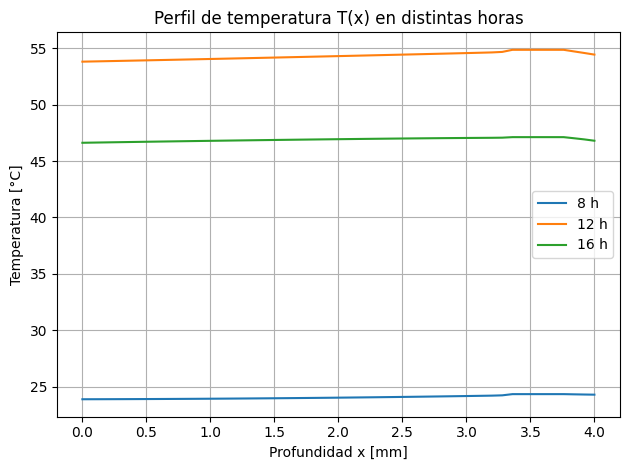

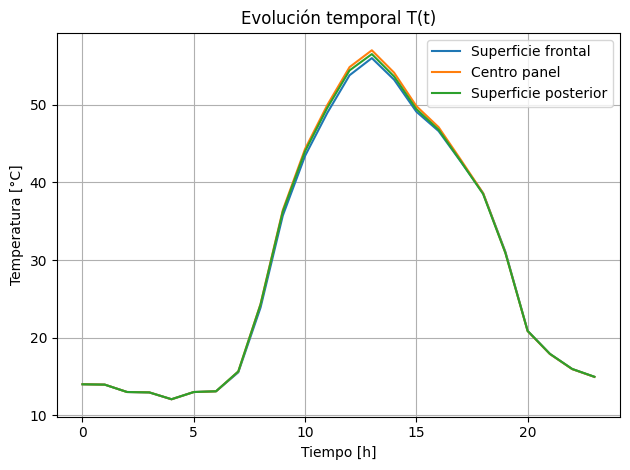

Tmax = 57.02 °C, Tmin = 12.06 °C


In [37]:
#grafico
horas_a_graficar = [8, 12, 16]

plt.figure()
for h in horas_a_graficar:
    t_obj = h * 3600
    idx = np.argmin(np.abs(t_vec - t_obj))
    plt.plot(x*1000, T_hist[idx] - 273.15, label=f"{h} h")

plt.xlabel("Profundidad x [mm]")
plt.ylabel("Temperatura [°C]")
plt.title("Perfil de temperatura T(x) en distintas horas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# perfil de temperatura en diferentes lugares del panel
idx_front = 0
x_centro_panel = 0.5*(interface[2] + interface[2+1])
idx_celda = np.argmin(np.abs(x - x_centro_panel))
idx_back  = n_x

plt.figure()
plt.plot(t_horas, T_hist[:, idx_front] - 273.15, label="Superficie frontal")
plt.plot(t_horas, T_hist[:, idx_celda] - 273.15, label="Centro panel")
plt.plot(t_horas, T_hist[:, idx_back]  - 273.15, label="Superficie posterior")

plt.xlabel("Tiempo [h]")
plt.ylabel("Temperatura [°C]")
plt.title("Evolución temporal T(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Temperaturas máxima y mínima
Tmax_K = np.max(T_hist)
Tmin_K = np.min(T_hist)
print(f"Tmax = {Tmax_K - 273.15:.2f} °C, Tmin = {Tmin_K - 273.15:.2f} °C")
